In [25]:
import dataset
import importlib
importlib.reload(dataset)
from dataset import DatasetCreation

In [26]:
from torch_geometric.utils import to_undirected,add_self_loops
from torch_geometric.data import Data
import itertools
import torch
import numpy as np 

In [ ]:
# #Creating the data, e.g., in this example, we create 1000 graphs with 10 nodes, 1000 with 15, etc.
# #We create graphs with varying number of nodes such that the neural network can learn to generalize.
# #Ideally we want many graphs and with many different number of nodes, but that can create computational problems if we lack the resources
# #or it the GNN we consider have many parameters.
# #Also, the bigger the graph, the more time concorde will need for solving (NP-hard problem)

# data_list = []

# num_datasets = 100

# for num_nodes in [5, 10, 12, 15]:
#   node_coords, distance_matrices,solution_paths, solution_adjacencies, distances = DatasetCreation.create_dataset(num_nodes = num_nodes,  num_datasets = num_datasets)

#   # Peso para el entrenamiento de la red neuronal, mayor número de nodos mayor peso tiene en el entrenamiento. 
#   num_pos = num_nodes
#   num_neg = num_nodes**2-num_nodes

#   weight_pos_class = (num_neg/num_pos)

#   edge_index = torch.tensor(list(itertools.product(np.arange(num_nodes),np.arange(num_nodes))), dtype=torch.long).T.contiguous()
#   for i in range(len(node_coords)):
#       edge_attr = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)

#       x = torch.tensor(node_coords[i]).float()
#       y = torch.tensor(solution_adjacencies[i].flatten()).float().unsqueeze(1)


#       data = Data(x=x, edge_index=edge_index, y= y, edge_attr=edge_attr)
#       data.edge_weight = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)
#       data.true_path = torch.Tensor(solution_paths[i])
#       data.true_distance = torch.Tensor([distances[i]]).unsqueeze(1)
#       data.num_nodes = num_nodes
#       data.pos_class_weight = weight_pos_class
#       data.disntace_matrices = distance_matrices
#       data_list.append(data)

In [27]:
import torch

# ⚠️ Solo si confías plenamente en el origen del fichero
data_list = torch.load("tsps.pt", weights_only=False)


In [28]:
ejemplo = data_list[13]
print
print("Nodos del problema:")
print(ejemplo.x.tolist())
print("\nAristas por donde pasa el tour (1 si para , 0 si no pasa):")
print(ejemplo.y.tolist())
print("\nCamino más corto")
print(ejemplo.true_path.tolist())
print("\nDistancia total del tour:")
print(ejemplo.true_distance.tolist())
print("\nPeso para la red neuronal:")
print(ejemplo.pos_class_weight)

Nodos del problema:
[[86.65316772460938, 44.298583984375], [97.84928894042969, 0.9275677800178528], [94.71952056884766, 97.0697250366211], [59.6941032409668, 5.331300735473633], [24.10684585571289, 55.332035064697266]]

Aristas por donde pasa el tour (1 si para , 0 si no pasa):
[[0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0]]

Camino más corto
[0.0, 2.0, 4.0, 3.0, 1.0]

Distancia total del tour:
[[279.9829406738281]]

Peso para la red neuronal:
4.0


In [29]:
import solutions
importlib.reload(dataset)
from solutions import SolutionAnalysys

In [30]:
#split the data to train, test, val

from torch_geometric.loader import DataLoader
import random

total_length = len(data_list)

# Calculate lengths of each part based on percentages
train_length = int(total_length * 0.7)
val_length = int(total_length * 0.1)

shuffled_list = random.sample(data_list, len(data_list))

# train, validate, test = np.split(data_list, [int(len(data_list)*0.7), int(len(data_list)*0.8)])
train_list = shuffled_list[:train_length]
val_list = shuffled_list[train_length:train_length + val_length]
test_list = shuffled_list[train_length + val_length:]

In [31]:
#to train the GNN with graphs of different sizes, we have to create batches with each batch having graphs of the same size.
#(Not sure there is another way for this)

max_batch_size = 256  # Maximum batch size
train_batched_data = []

# Sort the datasets based on the number of nodes
sorted_datasets = sorted(train_list, key=lambda x: x.num_nodes)

for dataset in sorted_datasets:
    if not train_batched_data or train_batched_data[-1][-1].num_nodes != dataset.num_nodes:
        # If the current batch is empty or the last dataset in the current batch has a different number of nodes,
        # start a new batch with the current dataset
        train_batched_data.append([dataset])
    else:
        # If adding the current dataset to the last batch doesn't exceed the maximum batch size,
        # add it to the last batch
        current_batch = train_batched_data[-1]
        if sum(data.num_nodes for data in current_batch) + dataset.num_nodes <= max_batch_size:
            current_batch.append(dataset)
        else:
            # Otherwise, start a new batch with the current dataset
            train_batched_data.append([dataset])

print(len(train_batched_data))

59


In [32]:
val_batched_data = []

# Sort the datasets based on the number of nodes
sorted_datasets = sorted(val_list, key=lambda x: x.num_nodes)

for dataset in sorted_datasets:
    if not val_batched_data or val_batched_data[-1][-1].num_nodes != dataset.num_nodes:
        # If the current batch is empty or the last dataset in the current batch has a different number of nodes,
        # start a new batch with the current dataset
        val_batched_data.append([dataset])
    else:
        # If adding the current dataset to the last batch doesn't exceed the maximum batch size,
        # add it to the last batch
        current_batch = val_batched_data[-1]
        if sum(data.num_nodes for data in current_batch) + dataset.num_nodes <= max_batch_size:
            current_batch.append(dataset)
        else:
            # Otherwise, start a new batch with the current dataset
            val_batched_data.append([dataset])

In [33]:
test_batched_data = []

# Sort the datasets based on the number of nodes
sorted_datasets = sorted(test_list, key=lambda x: x.num_nodes)

for dataset in sorted_datasets:
    if not test_batched_data or test_batched_data[-1][-1].num_nodes != dataset.num_nodes:
        # If the current batch is empty or the last dataset in the current batch has a different number of nodes,
        # start a new batch with the current dataset
        test_batched_data.append([dataset])
    else:
        # If adding the current dataset to the last batch doesn't exceed the maximum batch size,
        # add it to the last batch
        current_batch = test_batched_data[-1]
        if sum(data.num_nodes for data in current_batch) + dataset.num_nodes <= max_batch_size:
            current_batch.append(dataset)
        else:
            # Otherwise, start a new batch with the current dataset
            test_batched_data.append([dataset])

In [34]:
#create the data loaders

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_batched_data, batch_size=None, shuffle=True)
val_loader = DataLoader(val_batched_data, batch_size=None, shuffle=True)
test_loader = DataLoader(test_batched_data, batch_size=None, shuffle=True)

In [35]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_geometric.utils import scatter
from torch_geometric.nn import MetaLayer
from torch import Tensor

from typing import Optional, Tuple


class EdgeModel(torch.nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        in_channels = ( 3 * hidden_dim )

        self.edge_mlp = Seq(BatchNorm1d(in_channels),
                            ReLU(),
                            Lin(in_channels, hidden_dim,bias=False))

    def forward(self, src, dst, edge_attr, edge_weight, u,  batch):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # edge_weight: [E, 1]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.

        # out = torch.cat([src, dst, edge_attr, u[batch]], 1)
        out = torch.cat([src, edge_attr,dst], 1)

        return self.edge_mlp(out) + edge_attr

class NodeModel(torch.nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        in_channels = ( 2 * hidden_dim)

        self.node_mlp_1 = Seq(BatchNorm1d(in_channels),
                              ReLU(),
                              Lin(in_channels, hidden_dim)
                              )
        self.node_mlp_2 = Seq(BatchNorm1d(in_channels),
                              ReLU(),
                              Lin(in_channels, hidden_dim))

    def forward(self, x, edge_index, edge_attr, edge_weight, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # edge_weight: [E, 1]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index


        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter(edge_weight.to(device)*out, col, dim=0, dim_size=x.size(0),
                      reduce='mean')
        out = torch.cat([x, out], dim=1)
        # out = torch.cat([x, out, u[batch]], dim=1)


        return self.node_mlp_2(out) + x

class GlobalModel(torch.nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        in_channels = ( 2 * hidden_dim)

        self.global_mlp = Seq(BatchNorm1d(in_channels),
                            ReLU(),
                            Lin(in_channels, hidden_dim,bias=False))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        out = torch.cat([
            u,
            scatter(x, batch, dim=0, reduce='mean'),
        ], dim=1)
        return self.global_mlp(out) + u

class MetaLayer(torch.nn.Module):
    def __init__(self,edge_model,node_model,global_model):
        super(MetaLayer, self).__init__()
        self.edge_model = edge_model
        self.node_model = node_model
        self.global_model = global_model

    def forward(
        self,
        x: Tensor,
        edge_index: Tensor,
        edge_attr: Optional[Tensor] = None,
        edge_weight: Optional[Tensor] = None,
        u: Optional[Tensor] = None,
        batch: Optional[Tensor] = None,
    ) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
        r"""Forward pass.

        Args:
            x (torch.Tensor): The node features.
            edge_index (torch.Tensor): The edge indices.
            edge_attr (torch.Tensor, optional): The edge features.
                (default: :obj:`None`)
            edge_weight (torch.Tensor, optional): The edge weight (scalar vector).
                (default: :obj:`None`)
            u (torch.Tensor, optional): The global graph features.
                (default: :obj:`None`)
            batch (torch.Tensor, optional): The batch vector
                :math:`\mathbf{b} \in {\{ 0, \ldots, B-1\}}^N`, which assigns
                each node to a specific graph. (default: :obj:`None`)
        """
        row = edge_index[0]
        col = edge_index[1]

        if self.edge_model is not None:
            edge_attr = self.edge_model(x[row], x[col], edge_attr, edge_weight, u,
                                        batch if batch is None else batch[row])

        if self.node_model is not None:
            x = self.node_model(x, edge_index, edge_attr, edge_weight, u, batch)

        if self.global_model is not None:
            u = self.global_model(x, edge_index, edge_attr, u, batch)

        return x, edge_attr, u


class METALAYER_TSP_SOLVER(torch.nn.Module):
    def __init__(self,node_input_dim, edge_input_dim, hidden_dim, decoder ='edge_emb', use_edge_weight=True):
        super(METALAYER_TSP_SOLVER, self).__init__()
        self.lin0_edge = Seq(Lin(edge_input_dim, hidden_dim,bias=False),BatchNorm1d(hidden_dim),ReLU())
        self.lin0_node = Seq(Lin(node_input_dim, hidden_dim,bias=False),BatchNorm1d(hidden_dim),ReLU())

        self.edge_lin1 = Lin((hidden_dim), hidden_dim)
        self.node_lin1 = Lin((hidden_dim*2), hidden_dim)
        self.nodes_edge_lin1 = Lin((hidden_dim*3), hidden_dim)


        self.lin2 = Lin(hidden_dim, 1)

        self.decoder = decoder

        self.use_edge_weight=use_edge_weight

        self.metalayer = MetaLayer(EdgeModel(hidden_dim), NodeModel(hidden_dim),  None)
        self.metalayer2 = MetaLayer(EdgeModel(hidden_dim), NodeModel(hidden_dim),  None)

    def forward(self, x, edge_index, edge_attr, edge_weight, u, batch):
        edge_attr = self.lin0_edge(edge_attr)
        x = self.lin0_node(x)

        if self.use_edge_weight==True and edge_weight is not None:
            edge_weight = torch.ones(edge_attr.shape[0],1)

        x, edge_attr, u = self.metalayer(x, edge_index, edge_attr, edge_weight, None, batch)
        x, edge_attr, u = self.metalayer2(x, edge_index, edge_attr, edge_weight, None, batch)

        if  self.decoder=='edge_emb':
            out = self.edge_lin1(edge_attr)
        elif self.decoder=='nodes_emb':
            row, col = edge_index
            z = torch.cat([x[row], x[col]], dim=-1)
            out = self.node_lin1(z)
        elif self.decoder=='edge_nodes_emb':
            row, col = edge_index
            z = torch.cat([x[row], edge_attr, x[col]], dim=-1)
            out = self.nodes_edge_lin1(z)
        elif self.decoder=='node_inner_product':
            row, col = edge_index
            out = (x[row]*x[col]).sum(dim=1).unsqueeze(1)
        elif self.decoder=='cond_node_inner_product':
            row, col = edge_index
            out = x[row]
            out = scatter(edge_weight*out, col, dim=0, dim_size=x.size(0),
                      reduce='mean')

            out = torch.cat([x, out], dim=-1)

            out = (out[row]*out[col]).sum(dim=1).unsqueeze(1)
        else:
            raise ValueError('Possible decoders are edge_emb, nodes_emb, edge_nodes_emb, node_inner_product, and cond_node_inner_product')

        if "inner_product" not in self.decoder:
            out = self.lin2(out)

        return out


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


edge_input_dim = 1
node_input_dim = 2
hidden_dim=128

use_edge_weight = True


num_epochs=16


model = METALAYER_TSP_SOLVER(node_input_dim,edge_input_dim, hidden_dim, decoder="node_inner_product",use_edge_weight=use_edge_weight)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00005)

criterion = torch.nn.BCEWithLogitsLoss(reduction='none')

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {pytorch_total_params}')


Number of parameters: 333185


In [37]:
def train(train_loader):
    model.train()
    l1_path_distances = 0
    l1_optimality_gaps = 0

    for train_data in train_loader:  # Iterate in batches over the training dataset.
        train_data.x = train_data.x.to(device)
        train_data.edge_index= train_data.edge_index.to(device)
        train_data.edge_attr = train_data.edge_attr.to(device)
        train_data.edge_weight = train_data.edge_weight.to(device)
        train_data.batch = train_data.batch.to(device)
        global_model_x=train_data.pos_class_weight.unsqueeze(1).to(device)
        out = model(train_data.x, train_data.edge_index,train_data.edge_attr, train_data.edge_weight, None, train_data.batch)  # Perform a single forward pass.
        train_loss = criterion(out, train_data.y.to(device))  # Compute the loss.

        batch_weights = torch.ones(train_loss.shape)

        mask = train_data.y.bool()  # Add a dimension to match the shape of ones_tensor
        batch_weights[mask.squeeze()] *= train_data.pos_class_weight[0]

        train_loss = train_loss * batch_weights.to(device)
        train_loss = train_loss.sum() / batch_weights.sum()

        train_loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        for_view = int(train_data.num_nodes/train_data.num_graphs)
        batch_out_heat_map=out.view((train_data.num_graphs, for_view,for_view))
        batch_truth_heat_map=train_data.true_path.view((train_data.num_graphs, for_view))
        batch_edge_weights=train_data.edge_weight.view((train_data.num_graphs, for_view, for_view))
        batch_true_distancess =  train_data.true_distance.view((train_data.num_graphs))

        l1_path_distance, l1_gap = SolutionAnalysys.mean_per_batch_optimality_metrics(batch_out_heat_map, batch_truth_heat_map, train_data.num_graphs,  for_view, batch_edge_weights,batch_true_distancess)
        l1_path_distances += l1_path_distance
        l1_optimality_gaps += l1_gap

    return train_loss, l1_path_distances/len(train_loader), l1_optimality_gaps/len(train_loader)

def test(loader):
    model.eval()
    l1_path_distances = 0
    l1_optimality_gaps = 0

    for test_data in loader:  # Iterate in batches over the training dataset.
        test_data.x = test_data.x.to(device)
        test_data.edge_index= test_data.edge_index.to(device)
        test_data.edge_attr = test_data.edge_attr.to(device)
        test_data.edge_weight = test_data.edge_weight.to(device)
        test_data.batch = test_data.batch.to(device)
        global_model_x=test_data.pos_class_weight.unsqueeze(1).to(device)
        out = model(test_data.x, test_data.edge_index,test_data.edge_attr, test_data.edge_weight, test_data.pos_class_weight.unsqueeze(1), test_data.batch)  # Perform a single forward pass.
        test_loss = criterion(out, test_data.y.to(device))  # Compute the loss.


        batch_weights = torch.ones(test_loss.shape).to(device)

        mask = test_data.y.bool()  # Add a dimension to match the shape of ones_tensor
        batch_weights[mask.squeeze()] *= test_data.pos_class_weight[0]

        test_loss = test_loss * batch_weights
        test_loss = test_loss.sum() / batch_weights.sum()


        for_view = int(test_data.num_nodes/test_data.num_graphs)

        batch_out_heat_map=out.view((test_data.num_graphs, for_view, for_view))
        batch_truth_heat_map=test_data.true_path.view((test_data.num_graphs, for_view))
        batch_edge_weights=test_data.edge_weight.view((test_data.num_graphs, for_view, for_view))
        batch_true_distancess =  test_data.true_distance.view((test_data.num_graphs))

        l1_path_distance, l1_gap = SolutionAnalysys.mean_per_batch_optimality_metrics(batch_out_heat_map, batch_truth_heat_map, test_data.num_graphs, for_view, batch_edge_weights,batch_true_distancess)
        l1_path_distances += l1_path_distance
        l1_optimality_gaps += l1_gap


    return test_loss, l1_path_distances/len(loader), l1_optimality_gaps/len(loader)

train_losses = []
test_losses = []
val_losses = []

train_l1_opt_gaps = []
test_l1_opt_gaps = []
val_l1_opt_gaps = []

for epoch in range(0, num_epochs+1):
    train_loss, train_l1_path_dist, train_opt_gap = train(train_loader)
    #we use the validation part also for training
    train_loss, train_l1_path_dist, train_opt_gap = train(val_loader)


    val_loss, val_l1_path_dist, val_opt_gap  = test(val_loader)

    test_loss, test_l1_path_dist, test_opt_gap  = test(test_loader)

    if epoch%5 ==0:
        print(f'Epoch: {(epoch+1):03d}')
        print(f'\t Train loss: {train_loss:.4f} L1 path dist: {train_l1_path_dist:.4f} opt. gap  {train_opt_gap:.4f}')
        print(f'\t Val loss: {val_loss:.4f} L1 path dist: {val_l1_path_dist:.4f} opt. gap  {val_opt_gap:.4f}')
        print(f'\t Test loss: {test_loss:.4f} L1 path dist: {test_l1_path_dist:.4f} opt. gap  {test_opt_gap:.4f}')
        print()

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    val_losses.append(val_loss.item())

    train_l1_opt_gaps.append(train_opt_gap.item())
    test_l1_opt_gaps.append(test_opt_gap.item())
    val_l1_opt_gaps.append(val_opt_gap.item())


Epoch: 001
	 Train loss: 0.9844 L1 path dist: 5.2780 opt. gap  0.0684
	 Val loss: 0.6655 L1 path dist: 5.3351 opt. gap  0.0553
	 Test loss: 0.6527 L1 path dist: 5.3523 opt. gap  0.0615

Epoch: 006
	 Train loss: 0.5581 L1 path dist: 4.2552 opt. gap  0.0344
	 Val loss: 0.5599 L1 path dist: 4.7666 opt. gap  0.0393
	 Test loss: 0.5464 L1 path dist: 4.8976 opt. gap  0.0470

Epoch: 011
	 Train loss: 0.5519 L1 path dist: 3.9361 opt. gap  0.0401
	 Val loss: 0.5443 L1 path dist: 4.5715 opt. gap  0.0453
	 Test loss: 0.5243 L1 path dist: 4.9427 opt. gap  0.0449

Epoch: 016
	 Train loss: 0.5151 L1 path dist: 4.2917 opt. gap  0.0461
	 Val loss: 0.5553 L1 path dist: 4.4438 opt. gap  0.0487
	 Test loss: 0.5342 L1 path dist: 5.1708 opt. gap  0.0494



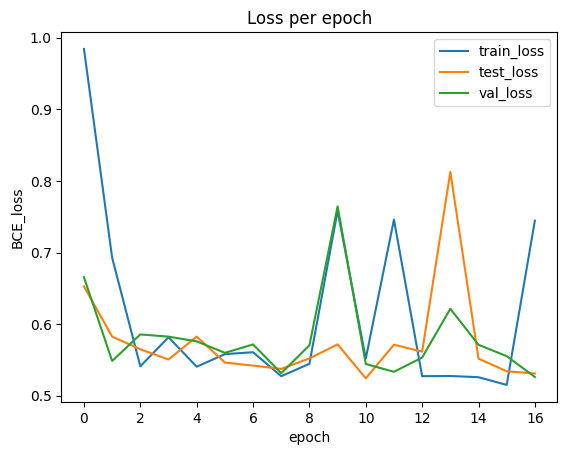

In [38]:
import matplotlib.pyplot as plt
# Plot the curves
plt.plot(train_losses,label='train_loss')
plt.plot(test_losses,label='test_loss')
plt.plot(val_losses,label='val_loss')
plt.xlabel('epoch')
plt.ylabel('BCE_loss')
plt.title('Loss per epoch')
plt.legend()
plt.show()

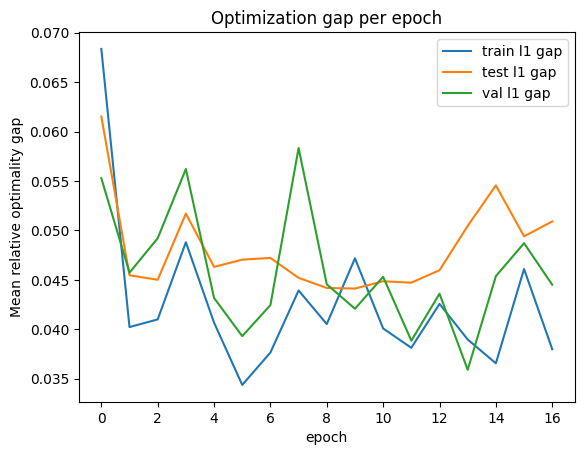

In [39]:
import matplotlib.pyplot as plt
# Plot the curves
plt.plot(train_l1_opt_gaps,label='train l1 gap')
plt.plot(test_l1_opt_gaps,label='test l1 gap')
plt.plot(val_l1_opt_gaps,label='val l1 gap')
plt.xlabel('epoch')
plt.ylabel('Mean relative optimality gap')
plt.title("Optimization gap per epoch")
plt.legend()
plt.show()

In [ ]:
from torch_geometric.utils import to_undirected,add_self_loops
from torch_geometric.data import Data
import itertools


new_data_list = []

num_datasets = 100

for num_nodes in [15]:
  node_coords, distance_matrices,solution_paths, solution_adjacencies, distances = DatasetCreation.create_dataset(num_nodes = num_nodes,  num_datasets = num_datasets)

  num_pos = num_nodes
  num_neg = num_nodes**2-num_nodes
  print(f'Number of solution edges {num_pos}')
  print(f'Number of false edges {num_neg} \n')


  weight_pos_class = (num_neg/num_pos)

  edge_index = torch.tensor(list(itertools.product(np.arange(num_nodes),np.arange(num_nodes))), dtype=torch.long).T.contiguous()
  for i in range(len(node_coords)):
      edge_attr = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)

      x = torch.tensor(node_coords[i]).float()
      y = torch.tensor(solution_adjacencies[i].flatten()).float().unsqueeze(1)


      data = Data(x=x, edge_index=edge_index, y= y, edge_attr=edge_attr)
      data.edge_weight = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)
      data.true_path = torch.Tensor(solution_paths[i])
      data.true_distance = torch.Tensor([distances[i]]).unsqueeze(1)
      data.num_nodes = num_nodes
      data.pos_class_weight = weight_pos_class
      new_data_list.append(data)



new_loader = DataLoader(new_data_list, batch_size=1, shuffle=False)

_, _, new_opt_gap = test(new_loader)

print(f'Mean relative opt. gap on new instances {new_opt_gap.item()}')